In [154]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import math
from typing import List, Tuple

In [93]:
# Load the dataset
df = pd.read_excel('data/processed/data_men_women.xlsx')
df = df[~df['Rank_Worldwide'].isna()]  # Filter out rows with missing 'Rank_Worldwide'
print(f"Rank range: {int(df['Rank_Worldwide'].min())}-{int(df['Rank_Worldwide'].max()):,}")

# Define bin edges and labels for the target variables of worldwide ranking
bins = [0, 3447, 9536, 21506, 34240, 54396, 164758]
labels = ["Top 2%", "2-6%", "6-12%", "12-21%", "21-30%", "30%+"]
df['Rank_Category'] = pd.cut(df['Rank_Worldwide'], bins=bins, labels=labels, right=True)

# Define features and target
features = ['Back Squat (lbs)', 'Clean and Jerk (lbs)', 'Deadlift (lbs)',
            'Snatch (lbs)', 'Fight Gone Bad', 'Max Pull-ups', 'Chad1000x (s)',
            'L1 Benchmark (s)', 'Filthy 50 (s)', 'Fran (s)', 'Grace (s)',
            'Helen (s)', 'Run 5k (s)', 'Sprint 400m (s)']
target = "Rank_Category"

# Split data into men and women
men_df = df[df['Division'] == "Men"]
women_df = df[df['Division'] == "Women"]

men_X = men_df[features]
men_y = men_df[target]

women_X = women_df[features]
women_y = women_df[target]

# Impute missing values with the mean
imp_men = SimpleImputer(strategy='mean')
men_X = imp_men.fit_transform(men_X)

imp_women = SimpleImputer(strategy='mean')
women_X = imp_women.fit_transform(women_X)

# Standardize the data
scaler = StandardScaler()
men_X = scaler.fit_transform(men_X)
women_X = scaler.fit_transform(women_X)

# Use one-hot encoding for multi-class classification
men_y_encoded = pd.get_dummies(men_y).values
women_y_encoded = pd.get_dummies(women_y).values

# Split into training and test sets
men_X_train, men_X_test, men_y_train, men_y_test = train_test_split(
    men_X, men_y_encoded, test_size=0.2, random_state=42, stratify=men_y_encoded.argmax(axis=1)
)
women_X_train, women_X_test, women_y_train, women_y_test = train_test_split(
    women_X, women_y_encoded, test_size=0.2, random_state=42, stratify=women_y_encoded.argmax(axis=1)
)

Rank range: 1-164,758


Men's Class Distribution:
Rank_Category
30%+      1077
21-30%    1027
2-6%       943
12-21%     915
6-12%      870
Top 2%     849
Name: count, dtype: int64

Women's Class Distribution:
Rank_Category
Top 2%    549
6-12%     527
12-21%    482
2-6%      454
21-30%    370
30%+      320
Name: count, dtype: int64


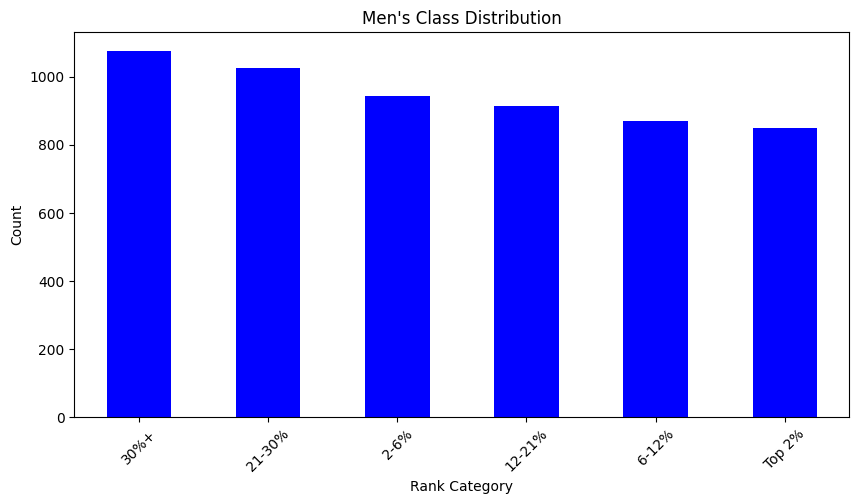

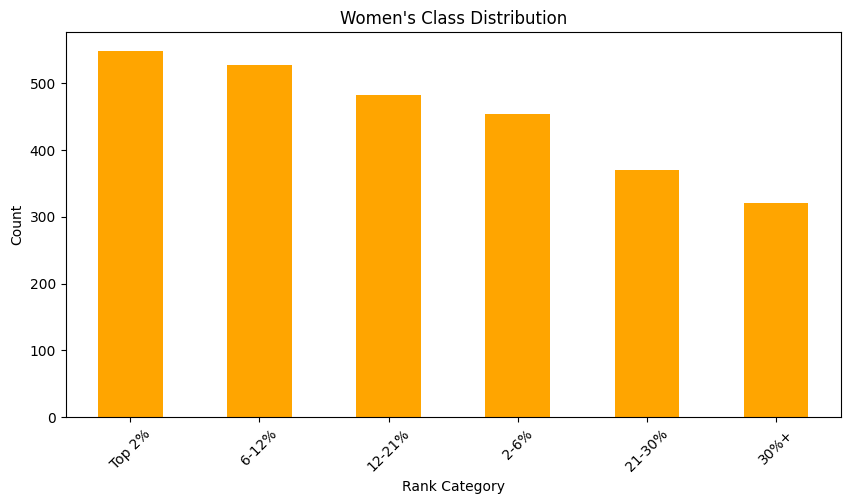

In [104]:
# Check class distribution for men
men_class_distribution = men_df['Rank_Category'].value_counts()
print("Men's Class Distribution:")
print(men_class_distribution)

# Check class distribution for women
women_class_distribution = women_df['Rank_Category'].value_counts()
print("\nWomen's Class Distribution:")
print(women_class_distribution)

# Plot class distribution 
def plot_class_distribution(class_distribution, title, color):
    plt.figure(figsize=(10, 5))
    class_distribution.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel("Rank Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(men_class_distribution, "Men's Class Distribution", 'blue')
plot_class_distribution(women_class_distribution, "Women's Class Distribution", 'orange')

In [96]:
# Function to build the neural network model
def create_model(activation='relu', neurons=32, num_classes=6, input_dim=men_X_train.shape[1], optimizer='adam'):
    """
    Creates a sequential model with specified parameters.

    Params:
      activation: Activation function for hidden layers (default: 'relu')
      neurons: Number of neurons in hidden layers (default: 32)
      num_classes: Number of output classes (default: 6)
      input_shape: Shape of the input data (default: None)
      optimizer: Optimizer to use (default: 'adam')

    Returns:
      Compiled Keras model
      
    """
    model = models.Sequential()
    model.add(Input(shape=(input_dim,)))  # Input layer
    model.add(layers.Dense(neurons, activation=activation))  # Hidden layer
    model.add(layers.Dense(neurons // 2, activation=activation))  # Hidden layers
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer
    
    # Compile model with specified optimizer
    optimizers_dict = {'adam': Adam(), 'sgd': SGD(), 'rmsprop': RMSprop()}
    if optimizer not in optimizers_dict:
        raise ValueError(f"Unknown optimizer: {optimizer}")
    
    model.compile(optimizer=optimizers_dict[optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define parameter grid
activations = ['relu', 'tanh', 'sigmoid']
neurons_list = [32, 64, 128]
optimizers = ['adam', 'sgd', 'rmsprop']
learning_rates = [0.001, 0.01, 0.1]

# Function to perform grid search for model
def grid_search(X_train, y_train, model_type='Men'):
    """
    Performs grid search for hyperparameter tuning.

    Params:
        X_train: Training data
        y_train: Training labels
        model_type: Model type for reference (default: 'Men')
        cv: Number of folds for cross-validation (default: 3)
        random_state: Seed for random shuffling (default: 42)

    Prints the best hyperparameters and their corresponding scores.
    """
    
    # Initialize a dictionary to house results
    results = {}
    
    # Determine the number of classes from the target variable
    num_classes = y_train.shape[1]

    for activation in activations:
        for neurons in neurons_list:
            for optimizer in optimizers:
                for lr in learning_rates:
                    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
                    scores = []
                    
                    for train_idx, val_idx in kfold.split(X_train):
                        model = create_model(activation=activation, neurons=neurons, num_classes=num_classes, input_dim=X_train.shape[1], optimizer=optimizer)
                        model.fit(X_train[train_idx], y_train[train_idx], epochs=50, batch_size=32, verbose=0)
                        loss, accuracy = model.evaluate(X_train[val_idx], y_train[val_idx], verbose=0)

                        # Get predictions and calculate precision, recall, F1 score
                        predictions = model.predict(X_train[val_idx])
                        predictions_classes = np.argmax(predictions, axis=1)
                        true_classes = np.argmax(y_train[val_idx], axis=1)

                        precision = precision_score(true_classes, predictions_classes, average='weighted', zero_division=0)
                        recall = recall_score(true_classes, predictions_classes, average='weighted')
                        f1 = f1_score(true_classes, predictions_classes, average='weighted')

                        scores.append((loss, accuracy, precision, recall, f1))  # Store all scores
                        
                    # Average scores for all folds
                    avg_loss = np.mean([score[0] for score in scores])
                    avg_accuracy = np.mean([score[1] for score in scores])
                    avg_precision = np.mean([score[2] for score in scores])
                    avg_recall = np.mean([score[3] for score in scores])
                    avg_f1 = np.mean([score[4] for score in scores])
                    
                    results[(activation, neurons, optimizer, lr)] = (avg_loss, avg_accuracy, avg_precision, avg_recall, avg_f1)

    best_params = max(results, key=lambda x: results[x][1])  # Maximize accuracy
    print(f"Best Params for {model_type}: Activation: {best_params[0]}, Neurons: {best_params[1]}, Optimizer: {best_params[2]}, Learning Rate: {best_params[3]}")
    best_score = results[best_params]
    print(f"Best Scores for {model_type}: Loss: {best_score[0]:.4f}, Accuracy: {best_score[1] * 100:.2f}%, Precision: {best_score[2]:.2f}, Recall: {best_score[3]:.2f}, F1 Score: {best_score[4]:.2f}")

# Train and evaluate model for men
print("Training model for Men:")
grid_search(men_X_train, men_y_train, model_type='Men')

# Train and evaluate model for women
print("\nTraining model for Women:")
grid_search(women_X_train, women_y_train, model_type='Women')

Training model for Men:
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
4

The results of the grid search suggest the following best hyperparameters for the neural network:
- Men's Division Model 
    - Best Params:
        - Activation Function: Sigmoid
        - Number of Neurons: 128
        - Optimizer: Root Mean Square Propagation (rmsprop)
        - Learning Rate: 0.001
- Women's Division Model    
    - Best Params:
        - Activation Function: Sigmoid
        - Number of Neurons: 64
        - Optimizer: Root Mean Square Propagation (rmsprop)
        - Learning Rate: 0.001

In [120]:
# Create neural network model with the best parameters
men_model = create_model(
    activation='sigmoid', 
    neurons=128, 
    optimizer='rmsprop', 
    learning_rate=0.001, 
    input_dim=men_X_train.shape[1], 
    num_classes=men_y_train.shape[1]
)

women_model = create_model(
    activation='sigmoid', 
    neurons=64, 
    optimizer='rmsprop', 
    learning_rate=0.001, 
    input_dim=women_X_train.shape[1], 
    num_classes=women_y_train.shape[1]
)

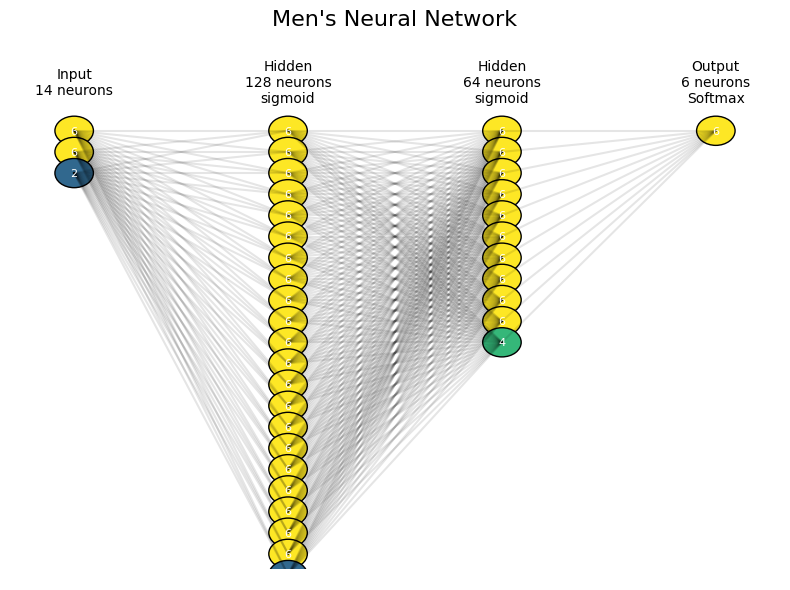

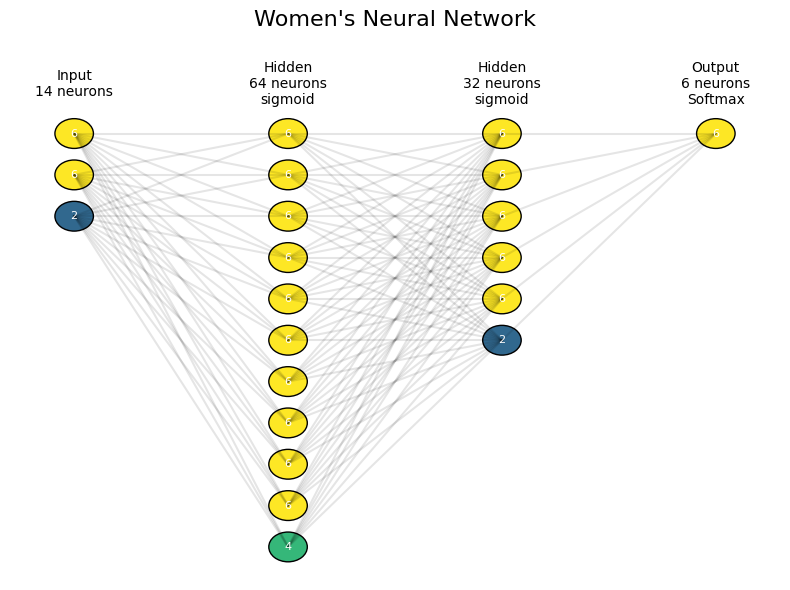

In [152]:
# Visualize the neural network models
def plot_neural_network(layer_sizes: List[int], activations: List[str], title: str, neurons_per_circle: int = 6):
    """
    Plot a visualization of the neural network architecture.
    
    Params:
        layer_sizes: List of neuron counts for each layer
        activations: List of activation functions for each layer
        title: Title of the plot
        neurons_per_circle: Number of neurons represented by each circle
    
    Returns:
        None
    """
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    n_layers = len(layer_sizes)
    
    # Calculate horizontal positions for each layer
    layer_positions = np.linspace(0, 1, n_layers)
    
    # Calculate the maximum number of circles in any layer
    max_circles = max(math.ceil(size / neurons_per_circle) for size in layer_sizes)
    
    # Calculate vertical spacing between circles
    v_spacing = 1 / (max_circles + 1)
    
    # Iterate through each layer
    for i, (size, x_coord) in enumerate(zip(layer_sizes, layer_positions)):
        # Calculate number of circles needed for this layer
        n_circles = math.ceil(size / neurons_per_circle)
        layer_top = 0.9  # Y-coordinate for the top of the layer
        
        # Draw circles for each group of neurons in the layer
        for j in range(n_circles):
            # Calculate number of neurons represented by this circle
            neurons_in_group = min(neurons_per_circle, size - j * neurons_per_circle)
            
            # Choose color based on how full the circle is
            color = plt.cm.viridis(neurons_in_group / neurons_per_circle)
            
            # Create and add the circle
            circle = plt.Circle((x_coord, layer_top - j * v_spacing), 0.03, facecolor=color, edgecolor='black')
            ax.add_artist(circle)
            
            # Add text to show number of neurons in the circle
            ax.text(x_coord, layer_top - j * v_spacing, str(neurons_in_group), ha='center', va='center', fontsize=8, color='white')
        
        # Add labels at the top of each layer
        layer_label = get_layer_label(i, n_layers, size, activations)
        ax.text(x_coord, 1.0, layer_label, ha='center', va='center')
    
    # Draw connections between layers
    plot_connections(ax, layer_positions, layer_sizes, neurons_per_circle, v_spacing)
    
    # Set plot limits and remove axes
    ax.set_xlim((-0.1, 1.1))
    ax.set_ylim((0, 1.1))
    ax.axis('off')
    
    # Add title and show the plot
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def get_layer_label(i: int, n_layers: int, size: int, activations: List[str]) -> str:
    """
    Generate the label for a layer based on its position and properties.
    
    Params:
        i: Index of the layer
        n_layers: Total number of layers
        size: Number of neurons in the layer
        activations: List of activation functions

    Returns:
        Formatted string label for the layer
    """
    if i == 0:
        return f"Input\n{size} neurons"
    elif i == n_layers - 1:
        return f"Output\n{size} neurons\nSoftmax"
    else:
        return f"Hidden\n{size} neurons\n{activations[i-1]}"

def plot_connections(ax, layer_positions: np.ndarray, layer_sizes: List[int], neurons_per_circle: int, v_spacing: float):
    """
    Plot connections between neurons in adjacent layers.
    
    Params:
        ax: Matplotlib axis to plot on
        layer_positions: X-coordinates of each layer
        layer_sizes: Number of neurons in each layer
        neurons_per_circle: Number of neurons represented by each circle
        v_spacing: Vertical spacing between circles
    
    Returns:
        None
    """
    for i in range(len(layer_sizes) - 1):
        # Calculate number of circles in current and next layer
        n_circles_left = math.ceil(layer_sizes[i] / neurons_per_circle)
        n_circles_right = math.ceil(layer_sizes[i+1] / neurons_per_circle)
        
        # Generate all connections between circles in adjacent layers
        connections = [
            (layer_positions[i:i+2], [0.9 - j * v_spacing, 0.9 - k * v_spacing])
            for j in range(n_circles_left)
            for k in range(n_circles_right)
        ]
        
        # Plot each connection
        for x, y in connections:
            ax.plot(x, y, 'k-', alpha=0.1)

def visualize_model(X_train: np.ndarray, y_train: np.ndarray, layer_sizes: List[int], activations: List[str], title: str):
    """
    Visualize a neural network model.
    
    Params:
        X_train: Training data features
        y_train: Training data labels
        layer_sizes: List of hidden layer sizes
        activations: List of activation functions
        title: Title for the visualization
    """
    # Include input and output layer sizes in the full layer sizes
    full_layer_sizes = [X_train.shape[1]] + layer_sizes + [y_train.shape[1]]
    plot_neural_network(full_layer_sizes, activations, title)

# Visualize the men's model
men_layer_sizes = [128, 64]
men_activations = ['sigmoid', 'sigmoid', 'softmax']
visualize_model(men_X_train, men_y_train, men_layer_sizes, men_activations, "Men's Neural Network")

# Visualize the women's model
women_layer_sizes = [64, 32]
women_activations = ['sigmoid', 'sigmoid', 'softmax']
visualize_model(women_X_train, women_y_train, women_layer_sizes, women_activations, "Women's Neural Network")

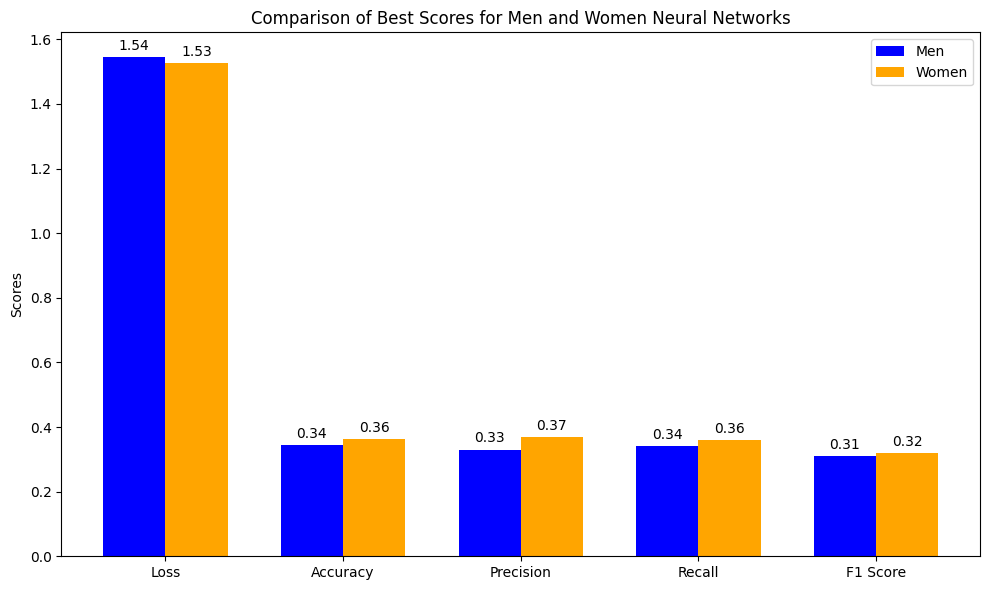

In [121]:
# Visualize the scores of each model using the best parameters
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

men_scores = [1.5444, 34.44, 0.33, 0.34, 0.31]
women_scores = [1.5261, 36.23, 0.37, 0.36, 0.32]

# Convert accuracy to decimals for consistency
men_scores[1] /= 100
women_scores[1] /= 100

# Plot setup
x = np.arange(len(metrics))
bar_width = 0.35  

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Men and Women
bars_men = ax.bar(x - bar_width/2, men_scores, bar_width, label='Men', color='blue')
bars_women = ax.bar(x + bar_width/2, women_scores, bar_width, label='Women', color='orange')

# Add labels, title, and custom ticks
ax.set_ylabel('Scores')
ax.set_title('Comparison of Best Scores for Men and Women Neural Networks')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add data labels for each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset the label above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')
add_labels(bars_men)
add_labels(bars_women)

# Show plot
plt.tight_layout()
plt.show()

The scores of the neural network are low. A high loss means that the model's predictions are far from the true rank. Only about one-third of the model's predictions are accurate. Both precision and recall are low, so the F1 score is also low. The model is not successful at detecting true positives and incorrectly predicts positives. 

Both the random forest and neural network models use the same features. Given the low scores for both models, this suggests the features do not have enough information to be accurate predictors of rankings. In other words, benchmark workout performance is not a good indicator of how that athlete will perform in the CrossFit games. 

Further exploration of other features that can be added to the model is needed to see if other variables are better predictors of ranking.